In [1]:
import sys
sys.path.append("../") # ugly way to have .py files in the PYTHONPATH

In [2]:
import pandas as pd
import tqdm
import graph_tool.all as gt

from utils import get_config, read_id_table, read_info_files

In [3]:
CONFIG = "../config.yaml"
DIR = ".."

In [4]:
config = get_config(CONFIG, section="alex")
datadir = get_config(CONFIG, section="files")["data_dir"]
info_file = get_config(CONFIG, section="files")["info_filename"]
citation_graph_file = config["citation_graph_file"]
id_table_file = config["id_table"]

df_info = pd.read_csv(f"{DIR}/{datadir}/{info_file}", index_col=0)

In [27]:
edges = []
df_edges = pd.read_csv(f"{DIR}/{datadir}/{citation_graph_file}")
for i, row in df_edges.iterrows():
    edges.append((row["cited paper"], row["citing paper"]))

In [6]:
# prepare nodes
id2alex, alex2id = read_id_table(f"{DIR}/{datadir}/{id_table_file}")

In [7]:
nodes = id2alex.keys()
print(len(nodes))

2189


In [8]:
g = gt.Graph(directed=True)
node_id = g.new_vp("string")
id2node = {}

In [9]:
for node in nodes:
     gnode = g.add_vertex()
     node_id[gnode] = node
     id2node[node] = gnode

In [10]:
for node1, node2 in edges:
    gnode1, gnode2 = id2node[node1], id2node[node2]
    if gnode1 != gnode2:
        g.add_edge(gnode2, gnode1) # edge from citing to cited

In [50]:
node_size = g.new_vp("int")
node_color = g.new_vp("string")
node_shape = g.new_vp("string", val="circle")
node_halo = g.new_vp("bool", val=False)

def is_author(node, author="Hutter"):
    id_ = node_id[node]
    authors = df_info[df_info["id"] == id_]["authors"].values[0]
    return author in authors

for node in g.vertices():
    node_size[node] = node.in_degree()+1
    if is_author(node, author="Vidnerov"):
        node_color[node] = "blue"
        node_halo[node] = True
        print("hola hop")
    elif is_author(node):
        node_color[node] = "red"
    else:
        node_color[node] = "gray"

hola hop


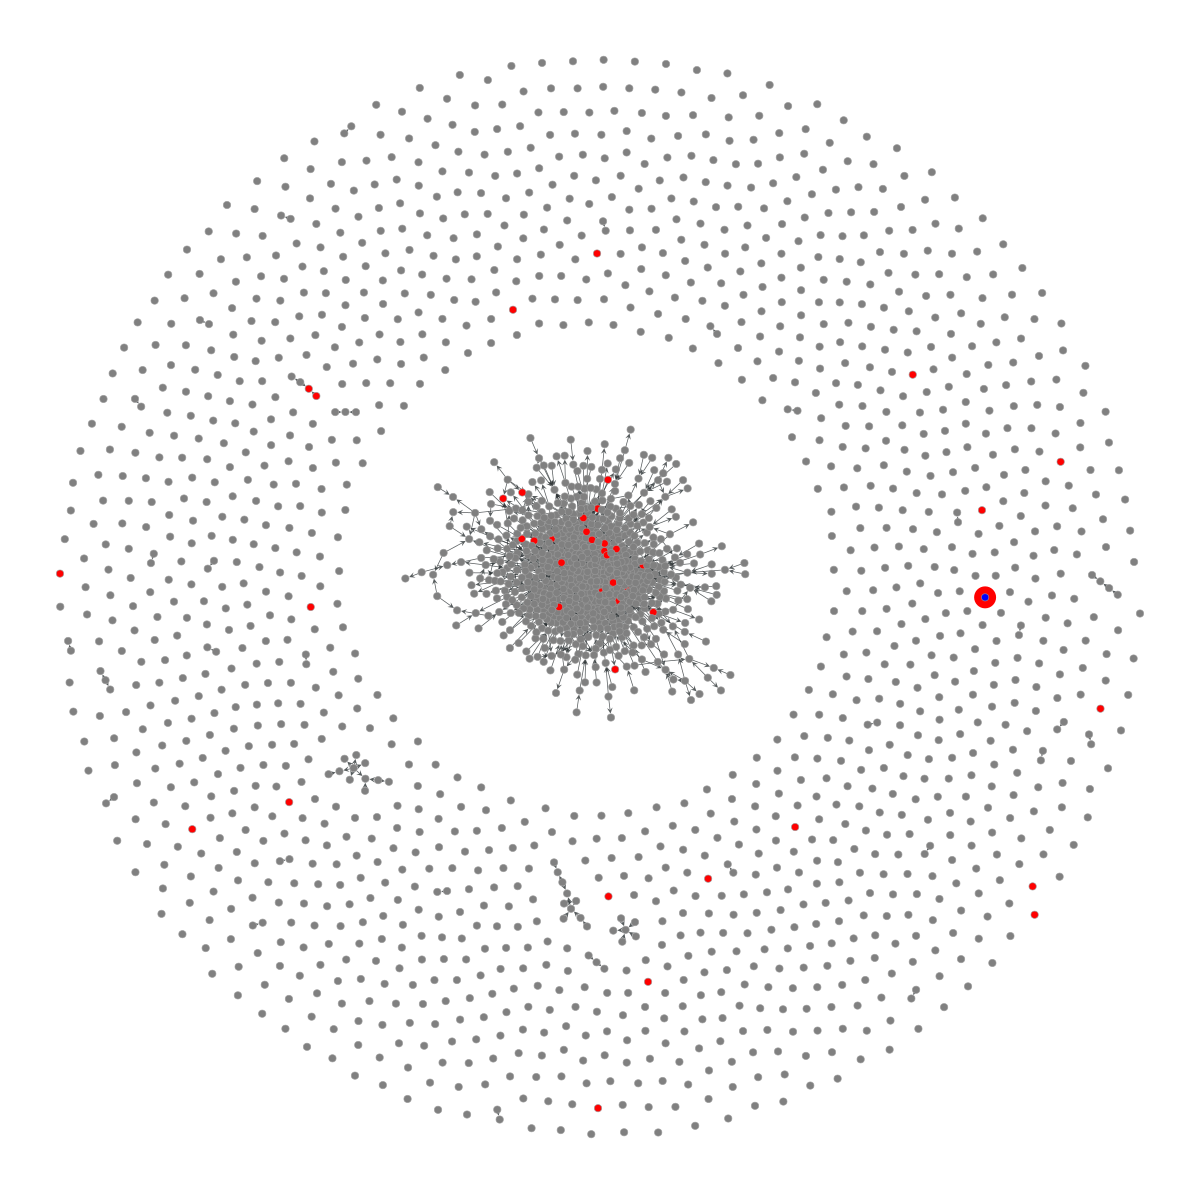

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7a4e8c15e2a0, at 0x7a4e89f09400>

In [53]:
gt.graph_draw(g,vertex_fill_color=node_color, vertex_shape=node_shape, vertex_halo=node_halo, vertex_halo_size=3.0,
             vertex_halo_color="red")

In [ ]:
u = gt.GraphView(g, vfilt=lambda v:  v.in_degree() + v.out_degree() >= 1)
gt.graph_draw(u)

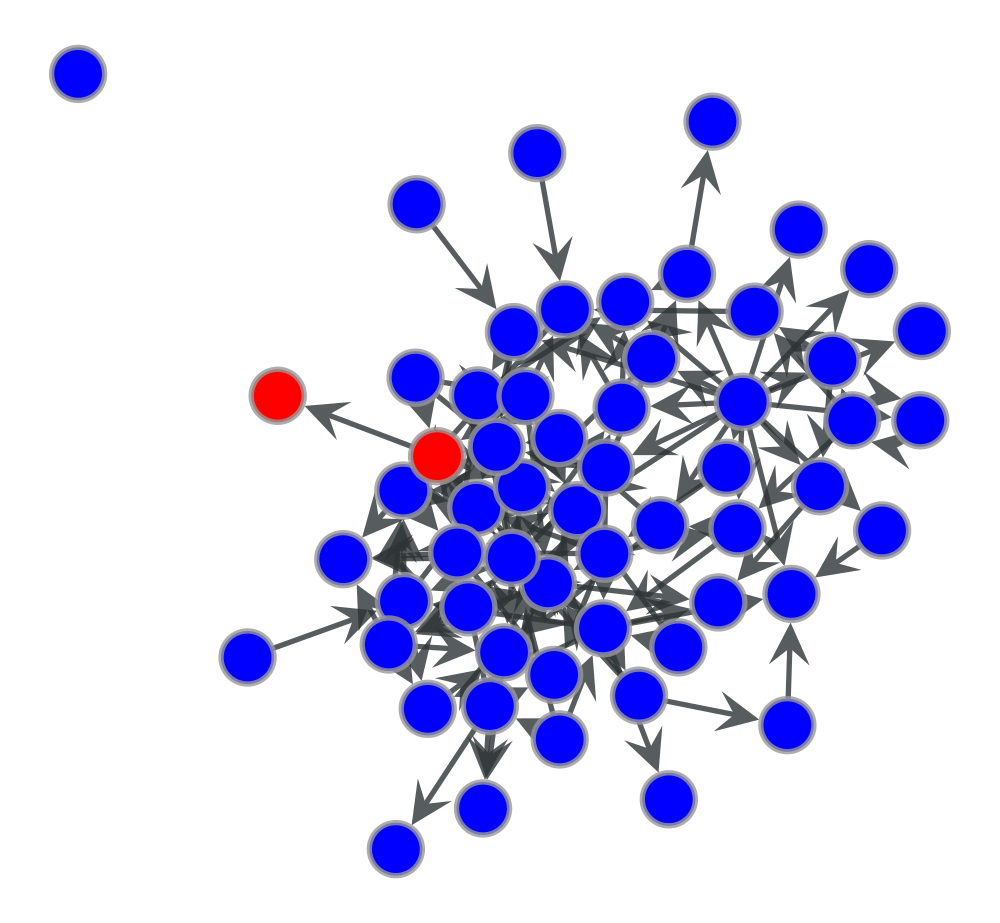

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7a4e89bd6000, at 0x7a4e89bd5e50>

In [14]:
v = gt.GraphView(g, vfilt=lambda v:  v.in_degree() >= 10)
gt.graph_draw(v, output_size=(500,1000), vertex_fill_color=node_color)

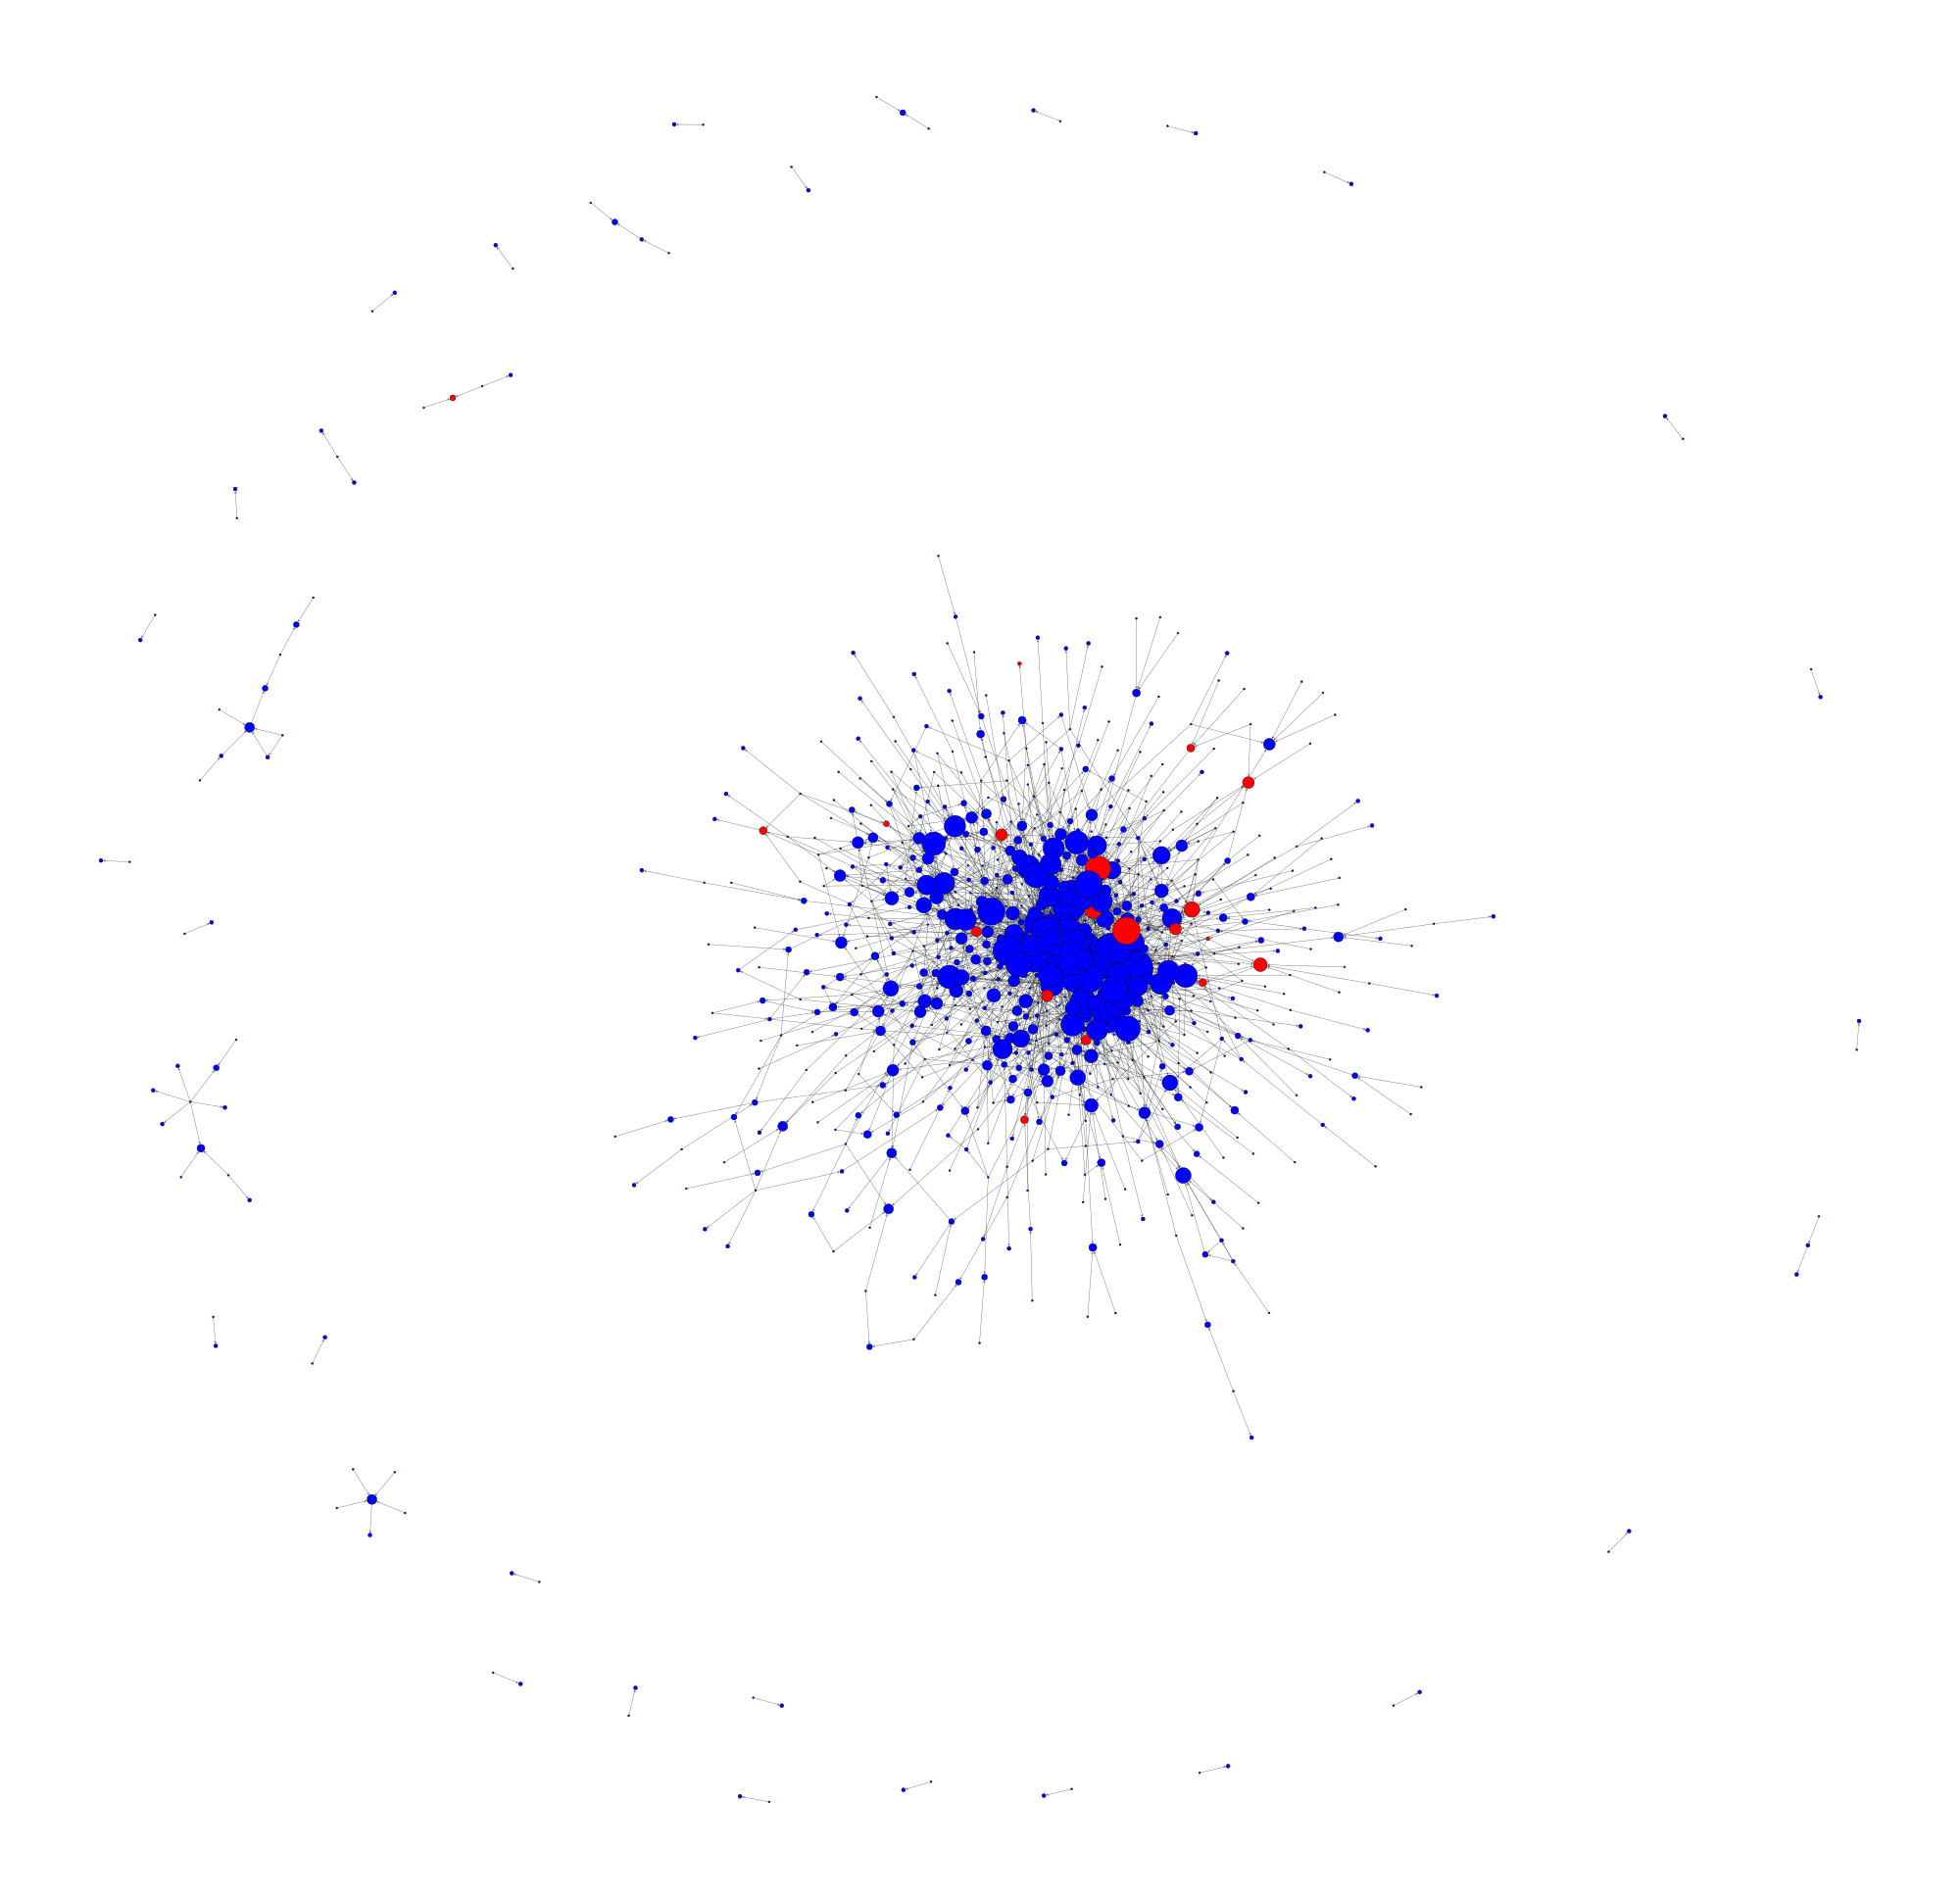

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7a4e89bd5f70, at 0x7a4e89bd7050>

In [15]:
z = gt.GraphView(g, vfilt=lambda v: v.in_degree() + v.out_degree()  > 0)
gt.graph_draw(z, vertex_size=node_size, 
              vertex_color="black", vertex_fill_color=node_color, output_size=(1000, 1000))

In [16]:
df_info[df_info["title"].apply(lambda x: "Surprisingly Strong" in x)]["id"].values[0]

'http://arxiv.org/abs/2404.16551v2'

In [17]:
"http://arxiv.org/abs/2404.16551v2" in id2alex

True

In [18]:
from download_references import get_openalex_id_from_arxiv

get_openalex_id_from_arxiv("http://arxiv.org/abs/2404.16551v2")


'https://openalex.org/W4395687037'

In [19]:
sorted_nodes = sorted(g.vertices(), key=lambda v: v.in_degree(), reverse=True)

In [20]:
for i in range(20):
    id_ = node_id[sorted_nodes[i]]
    title = df_info[df_info["id"] == id_]["title"].values[0]
    authors = df_info[df_info["id"] == id_]["authors"].values[0]
    print(authors, ":", title)
        

Sirui Xie;Hehui Zheng;Chunxiao Liu;Liang Lin : SNAS: Stochastic Neural Architecture Search
Han Cai;Ligeng Zhu;Song Han : ProxylessNAS: Direct Neural Architecture Search on Target Task and
  Hardware
Xuanyi Dong;Yi Yang : NAS-Bench-201: Extending the Scope of Reproducible Neural Architecture
  Search
Jieru Mei;Yingwei Li;Xiaochen Lian;Xiaojie Jin;Linjie Yang;Alan Yuille;Jianchao Yang : AtomNAS: Fine-Grained End-to-End Neural Architecture Search
Liam Li;Ameet Talwalkar : Random Search and Reproducibility for Neural Architecture Search
Andrew Brock;Theodore Lim;J. M. Ritchie;Nick Weston : SMASH: One-Shot Model Architecture Search through HyperNetworks
Hieu Pham;Melody Y. Guan;Barret Zoph;Quoc V. Le;Jeff Dean : Efficient Neural Architecture Search via Parameter Sharing
Han Cai;Tianyao Chen;Weinan Zhang;Yong Yu;Jun Wang : Efficient Architecture Search by Network Transformation
Shen Yan;Yu Zheng;Wei Ao;Xiao Zeng;Mi Zhang : Does Unsupervised Architecture Representation Learning Help Neural
  

In [21]:
all_authors=set()
for i, row in df_info.iterrows():
    authors = row["authors"].strip().split(";")
    all_authors.update(authors)
len(all_authors)

7098

In [22]:
number_of_papers = dict()
for author in all_authors:
    number_of_papers[author] = df_info["authors"].apply(lambda x: author in x).sum()
sorted_authors = sorted(all_authors, key=lambda x: number_of_papers[x], reverse=True)

In [23]:
for i in range(200):
    author = sorted_authors[i]
    print(i, author, number_of_papers[author])


0 Frank Hutter 43
1 Yanan Sun 27
2 Alexander Wong 26
3 Yiyu Shi 23
4 Zhenguo Li 22
5 Qi Tian 19
6 Quoc V. Le 19
7 Yiran Chen 19
8 Quanming Yao 18
9 Weiwen Jiang 17
10 Mingxing Tan 17
11 Mohammad Javad Shafiee 17
12 Arber Zela 16
13 Bo Zhang 16
14 Zhangyang Wang 15
15 Xiaodan Liang 15
16 Xiangxiang Chu 14
17 Song Han 14
18 Hai Li 14
19 Bing Xu 14
20 Hang Xu 14
21 Junjie Yan 13
22 Lingxi Xie 13
23 Feng Yan 13
24 Binxin Ru 13
25 Yunhe Wang 13
26 Wanli Ouyan 13
27 Pengtao Xie 13
28 Yu Li 13
29 Chang Xu 13
30 Zhichao Lu 12
31 Luca Benini 12
32 Xiaojun Chang 12
33 Rongrong Ji 12
34 Yuandong Tian 12
35 Xin Chen 12
36 Shoukang Hu 12
37 Wanli Ouyang 12
38 Mengjie Zhang 12
39 Meng Li 12
40 Bing Xue 12
41 Chen Qian 12
42 Xin Wang 12
43 Xiaoliang Dai 12
44 Hanxiao Liu 12
45 Tunhou Zhang 11
46 Prasanna Balaprakash 11
47 Yang Li 11
48 Daniele Jahier Pagliari 11
49 Huan Zhao 11
50 Alessio Burrello 11
51 Xunying Liu 11
52 Xinyu Gong 11
53 Thomas Elsken 11
54 Matteo Risso 10
55 Mingkui Tan 10
56 Yong G

In [24]:
number_of_citations = dict()
for author in tqdm.tqdm(all_authors):
    paper_ids = df_info[df_info["authors"].apply(lambda x: author in x)]["id"]
    citations = []
    for pid in paper_ids:
        node = id2node.get(pid, None)
        if node is None:
            continue
        citations.append(node.in_degree())
    number_of_citations[author] = sum(citations)


    

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7098/7098 [00:03<00:00, 2072.80it/s]


In [25]:
sorted_authors = sorted(all_authors, key=lambda x: number_of_citations.get(x, 0), reverse=True)

In [26]:
for i in range(300):
    author = sorted_authors[i]
    print(i, author, number_of_citations[author])


0 Frank Hutter 92
1 Qi Tian 72
2 Han Cai 69
3 Yuandong Tian 63
4 Xin Chen 58
5 Zhenguo Li 57
6 Hanxiao Liu 57
7 Lingxi Xie 56
8 Song Han 56
9 Xiangxiang Chu 52
10 Bo Zhang 51
11 Alan Yuille 47
12 Barret Zoph 47
13 Yunhe Wang 46
14 Quoc V. Le 46
15 Thomas Elsken 44
16 Weinan Zhang 43
17 Yong Yu 43
18 Arber Zela 43
19 Bichen Wu 40
20 Qian Zhang 40
21 Peizhao Zhang 39
22 Xiaoliang Dai 39
23 Peter Vajda 38
24 Junjie Yan 37
25 Gabriel Bender 37
26 Pieter-Jan Kindermans 37
27 Mingxing Tan 36
28 Yuhui Xu 36
29 Xiaopeng Zhang 34
30 Gaofeng Meng 33
31 Chang Xu 33
32 Weiwen Jiang 32
33 Xuanyi Dong 32
34 Xiangyu Zhang 31
35 Sirui Xie 31
36 Jun Wan 31
37 Jun Wang 31
38 Ruijun Xu 31
39 Jian Sun 31
40 Jiashi Feng 30
41 Yukang Chen 30
42 Chenxi Liu 29
43 Wei Wei 29
44 Hehui Zheng 29
45 Chunxiao Liu 29
46 Quoc Le 28
47 Rodrigo Fonseca 28
48 Wei Wu 28
49 Renqian Luo 28
50 Kaicheng Yu 28
51 Tao Qin 28
52 Linnan Wang 28
53 Xiaojie Jin 28
54 Zhangyang Wang 27
55 Yiyu Shi 27
56 Xinyu Gong 27
57 Lihi Zelnik